In [36]:
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import yfinance as ytf

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA


from pmdarima.arima.utils import ndiffs


plt.style.use(style='seaborn')
%matplotlib inline

In [14]:
#Load the ticker data to a dataframe
df = ytf.Ticker('VWCE.DE')
df = df.history(period='max')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-29,72.220001,72.220001,71.849998,71.849998,351,0,0
2019-07-30,71.930000,71.959999,71.440002,71.440002,42,0,0
2019-07-31,71.419998,71.629997,71.419998,71.550003,37,0,0
2019-08-01,71.449997,72.010002,71.449997,71.989998,4340,0,0
2019-08-02,70.269997,70.279999,69.639999,69.639999,2401,0,0
...,...,...,...,...,...,...,...
2022-06-27,92.430000,92.940002,91.779999,92.110001,84907,0,0
2022-06-28,92.639999,93.430000,92.000000,92.110001,57180,0,0
2022-06-29,91.080002,91.739998,90.739998,91.470001,91386,0,0


## ADF test

In [16]:
#Check if price series is stationary
result = adfuller(df['Close'].dropna())
print(f'ADF Statistics: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistics: -1.224168267357746
p-value: 0.6631136965895299


## Autocorrelation function (ACF)

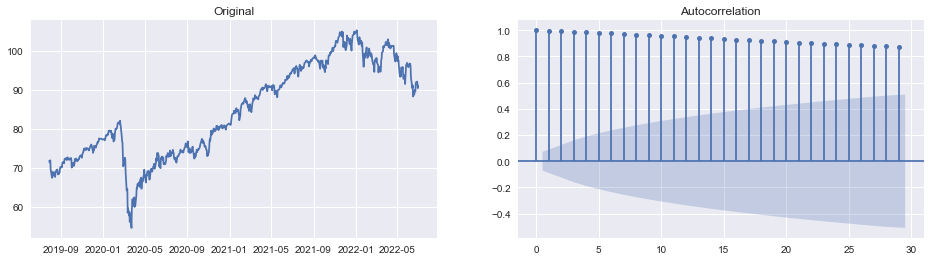

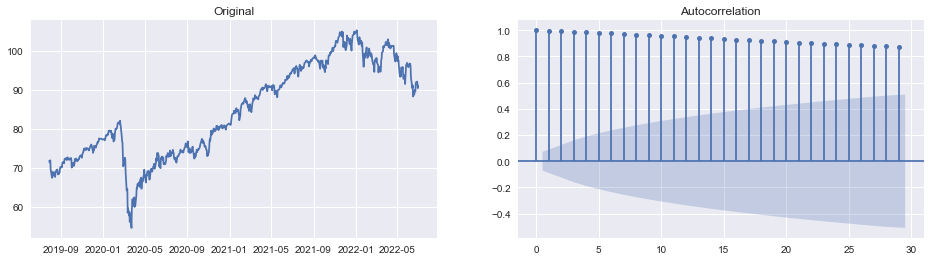

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df['Close'])
ax1.set_title('Original')

plot_acf(df['Close'], ax=ax2)

## Differencing

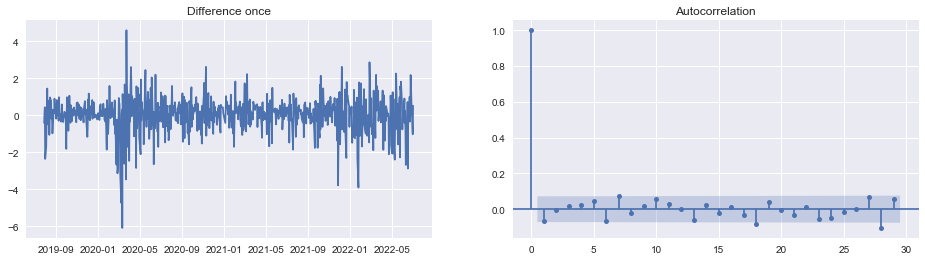

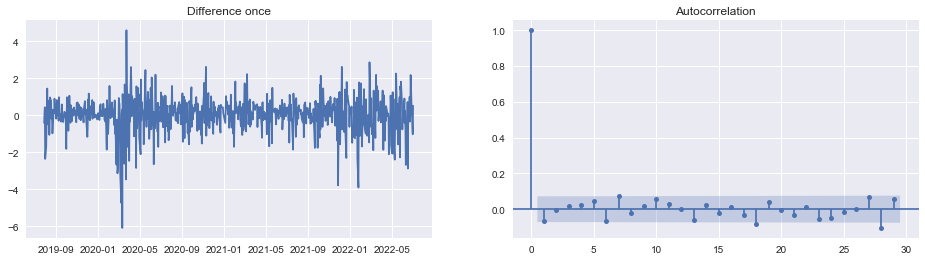

In [38]:
diff = df['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Difference once')

plot_acf(diff, ax=ax2)

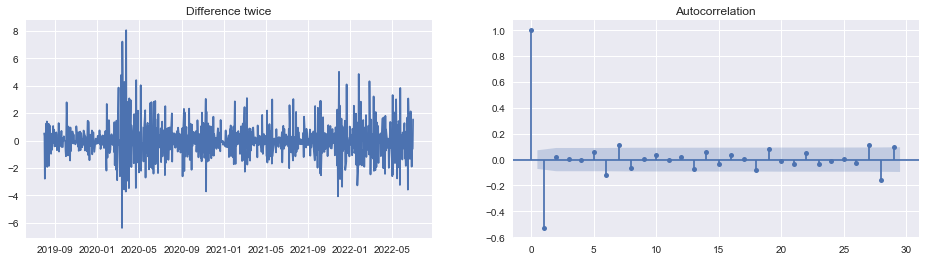

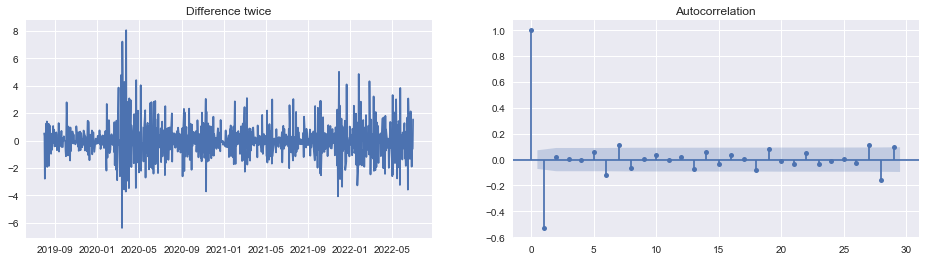

In [40]:
diff2 = diff.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff2)
ax1.set_title('Difference twice')

plot_acf(diff2, ax=ax2)

In [23]:
#Get differencing number
ndiffs(df['Close'], test='adf')

1

## Partial autocorrelation function (PACF)

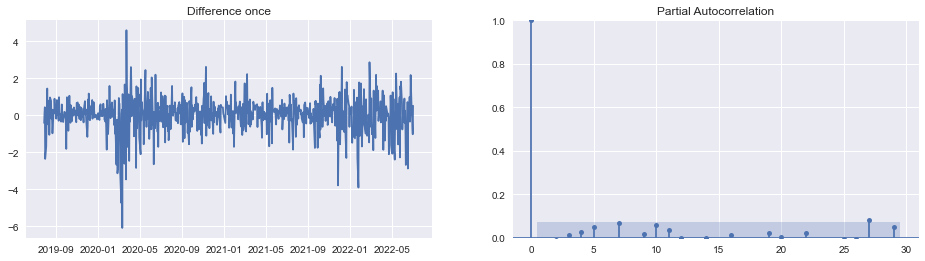

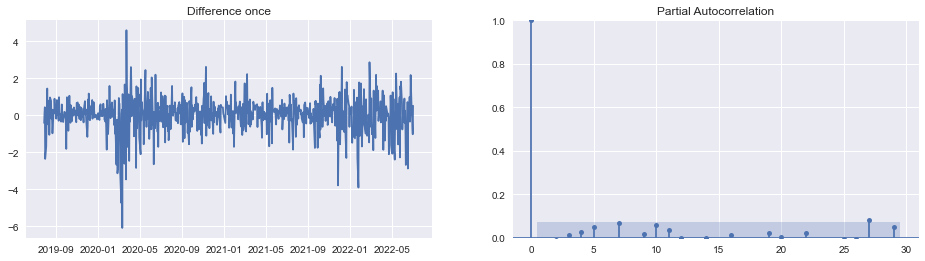

In [25]:
diff = df['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0, 1)

plot_pacf(diff, ax=ax2)

## Fitting the ARIMA model

In [44]:
model = ARIMA(df['Close'], order=(1, 0, 0))
result = model.fit(disp=0)
print(result.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  744
Model:                     ARMA(1, 0)   Log Likelihood               -1026.051
Method:                       css-mle   S.D. of innovations              0.958
Date:                Sat, 02 Jul 2022   AIC                           2058.103
Time:                        12:32:37   BIC                           2071.939
Sample:                             0   HQIC                          2063.436
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          83.1527      7.694     10.807      0.000      68.072      98.233
ar.L1.Close     0.9966      0.002    401.941      0.000       0.992       1.001
                                    Roots       

C:\Users\Gediminas\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Gediminas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated f

(array([0.00085041, 0.        , 0.        , 0.00085041, 0.00340166,
        0.01955954, 0.18198881, 0.38949006, 0.03571743, 0.00085041]),
 array([-11.30273282,  -9.72222678,  -8.14172074,  -6.56121469,
         -4.98070865,  -3.40020261,  -1.81969657,  -0.23919053,
          1.34131552,   2.92182156,   4.5023276 ]),
 <BarContainer object of 10 artists>)

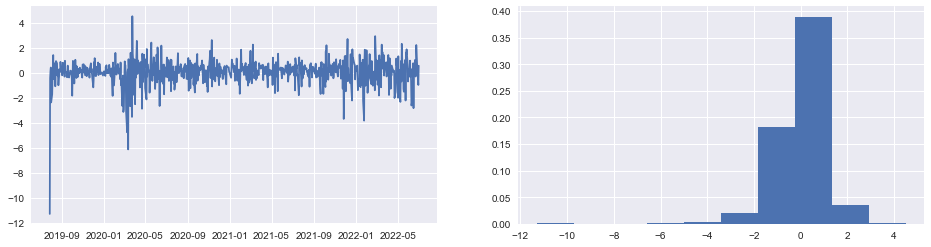

In [45]:
#Plot residual errors
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

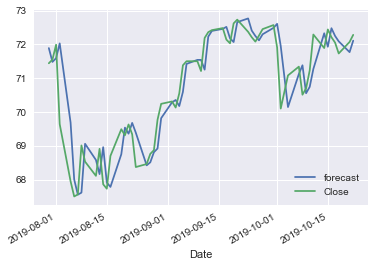

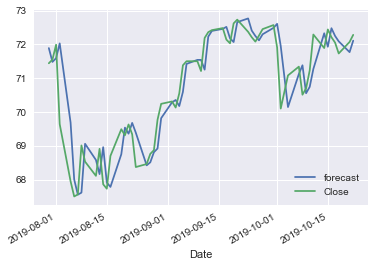

In [46]:
#Actual vs fitted
result.plot_predict(
    start=1,
    end=60,
    dynamic=False,
)

In [48]:
df_close = df[['Close']]
df_close

,Close
Date,
2019-07-29,71.849998
2019-07-30,71.440002
2019-07-31,71.550003
2019-08-01,71.989998
2019-08-02,69.639999
...,...
2022-06-27,92.110001
2022-06-28,92.110001
2022-06-29,91.470001


## Train test split

In [49]:
n = int(len(df_close) * 0.8)
train = df_close[:n]
test = df_close[n:]

print(len(train))
print(len(test))

595
149


In [50]:
model = ARIMA(train, order=(1, 0, 0))
result = model.fit(disp=0)
print(result.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  595
Model:                     ARMA(1, 0)   Log Likelihood                -782.897
Method:                       css-mle   S.D. of innovations              0.898
Date:                Sat, 02 Jul 2022   AIC                           1571.793
Time:                        12:41:08   BIC                           1584.959
Sample:                             0   HQIC                          1576.920
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          84.1523      9.881      8.516      0.000      64.785     103.519
ar.L1.Close     0.9976      0.002    419.566      0.000       0.993       1.002
                                    Roots       

C:\Users\Gediminas\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Gediminas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated f

In [66]:
step = 149

fc, se, conf = result.forecast(step)

In [67]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

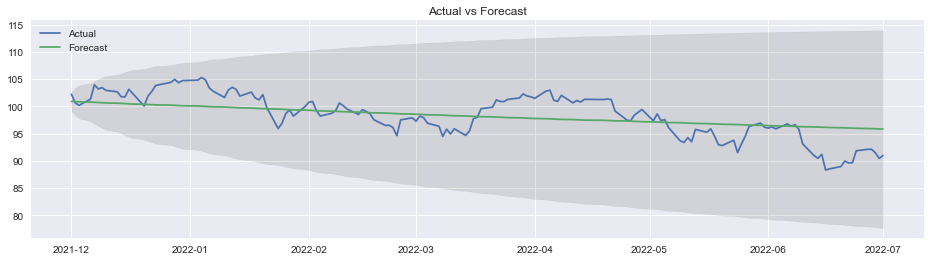

In [68]:
plt.figure(figsize=(16, 4))
plt.plot(test[:step], label='Actual')
plt.plot(fc[:step], label='Forecast')
plt.fill_between(lower.index, lower, upper, color='k', alpha=0.1)
plt.title("Actual vs Forecast")
plt.legend(loc='upper left')